# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [2]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [3]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]   #X has coordinates 1 (homogeneous repr), X[n-2], X[n-2]
Y_training = norm_data[2 : m_training]            #Y has the value we want to predict X[n]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


In [4]:
print(X_training[1,:])

[1.         0.62896851 0.627468  ]


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [5]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray):
    ## Run the LS algorithm without regularization
    A=np.dot(X_matrix.T, X_matrix)
    b=np.dot(X_matrix.T, labels)
    return np.matmul(np.linalg.inv(A), b)

def evaluate_model(x, y, coeff):
    ## Return the average MSE for the set over which we evaluate
    mse=(np.dot(x, coeff) - y)**2
    MSE=sum(mse)
    return MSE/len(mse)


In [6]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('MSE: ', mse, 'Root MSE:', np.sqrt(mse) * avg_size)

Model coefficients: [0.36986742 0.20348677 0.42565451]
MSE:  0.015483932733208612 Root MSE: 7712.354721539178


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [14]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    ## Run the LS algorithm with regularization
    A=np.dot(X_matrix.T, X_matrix)
    b=np.dot(X_matrix.T, labels)
    return np.matmul(np.linalg.inv(2*lambda_par*np.eye(A.shape[0])+A), b)

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## Perform K-fold cross-validation
    idx=list(range(len(X_training)))
    fold_points=int(np.floor(len(X_training)/K))
    x_fold=[]
    y_fold=[]
    for i in range(K):                              #partition into folds
        fold_idx=rnd.sample(idx, fold_points)
        idx= [i for i in idx if i not in fold_idx]
        x_fold.append(X_training[fold_idx])
        y_fold.append(Y_training[fold_idx])

    #print("x_folds: ", x_fold)

    best=-1
    best_perf=9e10
    best_lamb=0
    results=[]
    models=[]

    for lamb in lambda_vec:
        lamb_perf=0
        for i in range(K):
            x_k_train= np.concatenate([x_fold[l] for l in range(K) if l!=i])
            y_k_train= np.concatenate([y_fold[l] for l in range(K) if l!=i])
            p=regularized_least_squares(x_fold[i], y_fold[i], lamb)
            lamb_perf+=evaluate_model(x_fold[i], y_fold[i], p)
        lamb_perf/=K
        results.append(lamb_perf)
        models.append(regularized_least_squares(X_training, Y_training, lamb))
        if lamb_perf<best_perf:
            best_perf=lamb_perf
            best_lamb=lamb
            best=regularized_least_squares(X_training, Y_training, lamb)

    return best, best_perf, best_lamb, models, results

[0.36986742 0.20348677 0.42565451] [0.021401160724536853, 0.02140144882154816, 0.02140225845013848, 0.021403516700128838, 0.02140516121441089, 0.021407138528888096, 0.02140940270012521, 0.021411914165976643, 0.02141463879580662, 0.021417547095711482, 0.02142061354103063, 0.021423816013823378, 0.021427135327253842, 0.021430554822203494, 0.021434060024132544, 0.02143763835036767, 0.02144127885973831, 0.021444972037888255, 0.02144870961273132, 0.021452484395451946, 0.021456290143213225]


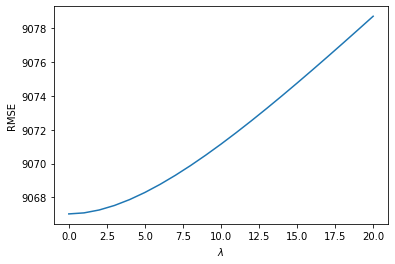

In [15]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(21)

best_model, best_perf, best_lamb, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


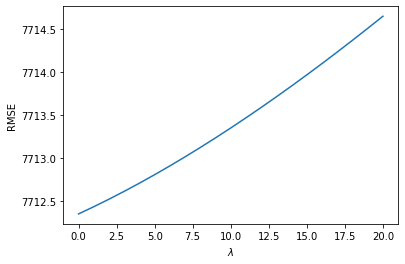

In [16]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


### EXTRA

Can you figure out the best amount of memory to use?
